# Modèle Q avec plusieurs blocs d'apprentissage


## Pourquoi modifier la tâche en rajoutant plusieurs blocs d'apprentissage?

Très souvent, pour bien estimer les paramètres, nous avons besoin de régressions qui sont suffisamment longues et suffisamment variables. Donc, nous pouvons modifier la tâche décrite dans le document "Qmodel", en rajoutant plusieurs blocs où les participants doivent apprendre la valeur de nouvelles machines à sous à chaque fois.



## Adaptation du code du  modèle pour plusieurs bloques

Le code est extrêmement similaire à celui du Qmodel, avec quelques petites adaptations.

### Définition des variables d'entrée

Nous avons deux paramètres libres: 
- le taux d'apprentissage, noté comme alpha
- la température inverse, beta, noté comme inv_temp

In [25]:
alpha      = 0.3;
inv_temp   = 1.5;

Définir le numbre d'essai et le numero de bloques d'apprentissage

In [26]:
ntrials = 24;
nruns   =  4;

Definir la valeur initiale de deux états

In [27]:
Q0  = [0 0]; % valeur initiale


### Initialisation des variables "output"

Nous allons initialiser des vecteurs vides dans lesquels les valeurs de chaque variable d'intérêt calculée par le modèle sont sauvegardées essai par essai.


In [29]:
Qt  = nan(ntrials+1, 2,nruns);  % valeur pour l'option B (col 1) et l'option A (col 2)
PE  = nan(ntrials, nruns);      % Erreur de prédiction
ch  = nan(ntrials, nruns);      % choix : 1 = B; 2 = A
PA  = nan(ntrials, nruns);      % probabilité de choisir A
r   = nan(ntrials, nruns);      % récompense obtenue

### Exécuter le modèle

Le modèle se base sur Rescorla-Wagner pour la mise à jour de la valeur de l'option choisie et sur softmax pour le calcul de la probabilité de choisir l'option avec la plus haute valeur.

Nous allons l'utiliser dans une boucle "for" qui va lire les essais un par un et exécuter les opérations suivantes :

1. **Calculer la probabilité de choisir A :** D'abord, il va calculer la probabilité de choisir l'option A en utilisant la fonction softmax (voir à la fin pour un approfodissement sur cette function).

$$
P_A(t) = \frac{1}{1 + e^{-\beta \cdot (Q_t(t,2) - Q_t(t,1))}}
$$


2. **Simuler le choix du modèle :** Ensuite, on simule le choix fait par le modèle (1 = B et 2 = A). On introduit un peu de stochasticité dans le choix en utilisant rand(). Si la probabilité de choisir A (entre 0 et 1) est plus grande qu'un nombre aléatoire entre 0 et 1, alors on choisit A (1+1), sinon on choisit B (1+0).

3. **Délivraison de la récompense :** La récompense est délivrée selon si une récompense est disponible dans la matrice des récompenses délivrables (O) et selon l'action (ch) qui a été faite (1 ou 2).

4. **Calculer de l'erreur de prédiction :** Différence entre valeur attendue et récompense observé

5. **Mise à de la valuer de l'option choisie :** Mise à jours de la valeur comme dans le modèle de Rescorla-Wagner.



In [30]:
for krun = 1:nruns
    
    % créeer la randomisation des récompenses qui pourraient être obtenue
    RA = rand(ntrials,1)<0.8;
    RB = rand(ntrials,1)<0.2;
    O = [RB, RA];


     Qt(1,:,krun)  = Q0; % initalise Q values

    % value simulation
    for t = 1:ntrials
    
        % 1 calculer la probabilté de choisr A
        PA(t,krun)   = 1./(1+exp(-inv_temp.*(Qt(t,2,krun)-Qt(t,1,krun))));
    
        % 2 simuler le choix du modèle (1 = option B, 2 = option A)
        ch(t,krun)   = 1 + double(rand()<PA(t,krun));
    
        % 3 délivrer la récompense
        r(t,krun) = O(t,ch(t,krun));
    
        % 4 calcule de l'erreur de prediction
        PE(t,krun) = r(t,krun) - Qt(t,ch(t,krun),krun);
    
        % 5 mise à jours de la valeur
        Qt(t+1,ch(t,krun),krun) = Qt(t,ch(t,krun),krun) + alpha.*PE(t,krun);    % colonne ch(t) = choisi (1 ou 2)
        Qt(t+1,3-ch(t,krun),krun) = Qt(t,3-ch(t,krun),krun);                    % colonne 3-ch(t) = pas choisi (2 ou 1)
    
    end
    
    
end

### Représentations graphiques des trajectoires temporelles des variables latentes

Tout d'abord il faut concatener les variables à travers les différents blocs d'apprentissage

In [33]:
% concaténer la matrice avec les valeurs de chaque option

Qt     = Qt(2:end,:,:); % enlever le premier 0 qui ne correspond pas à un essai
Qt_c   = num2cell(Qt, [1 2]); 
Qt_all = vertcat(Qt_c{:});

% concaténer le vecteur avec la probabilité de choisir A
PA_all = PA(:);

% concaténer le vecteur avec le choix
ch_all = ch(:);


<mark>The chosen color has been updated in the following code</mark>

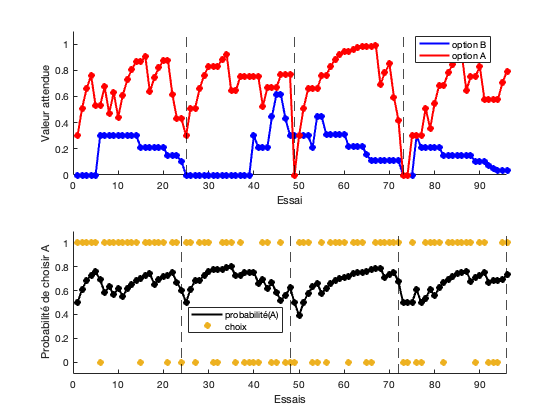

In [32]:
figure

% Pour les résultats des valeurs attendues
subplot(2, 1, 1)
hold on
valueA =  plot(Qt_all(:,1), '-b');
plot(Qt_all(:,1), 'ob', 'MarkerFaceColor', 'b');  % Points bleus pour chaque observation
valueB = plot(Qt_all(:,2), '-r');
plot(Qt_all(:,2), 'or', 'MarkerFaceColor', 'r');  % Points rouges pour chaque observation
set(valueA, 'LineWidth', 2);
set(valueB, 'LineWidth', 2);
% mettre un ligne verticale qui indique le début d'un bloc d'apprentissage 
for i = 1:nruns
    xline(i*ntrials+1, '--k'); 
end

xlim([0, ntrials*nruns]);
ylim([0, 1.1]);
xlabel('Essai');
ylabel('Valeur attendue');
legend([valueA, valueB],'option B','option A','Location','best');

% Pour les résultats des choix simulée
subplot(2, 1, 2);
hold on
pro = plot(PA_all, '-k');
plot(PA_all, 'ok', 'MarkerFaceColor', 'k');  % Points noirs pour chaque observation
set(pro, 'LineWidth', 2);
ch = plot(ch_all-1, 'o','MarkerFaceColor', [0.9290 0.6940 0.1250]);  % Points  jaunes pour chaque observation);
xlim([0, ntrials*nruns]);
% mettre un ligne verticale qui indique le début d'un block d'apprentissage 
for i = 1:nruns
    xline(i*ntrials, '--k'); 
end
ylim([-0.1, 1.1]);
xlabel('Essais');
ylabel('Probabilité de choisir A');
legend([pro,ch],'probabilité(A)','choix','Location','best');
